In [1]:
# General imports:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Imports for data handling:
from torch.utils.data import DataLoader

# Imports for model training:
import torch
from torch import nn, optim
from torch.nn import Sequential, Linear, ReLU

from dataset import EarthSystemsDataset
from nn_util import EarthSystemsNN, Trainer

In [2]:
def sequence1(in_size, label_size):
    layers = [
        Linear(in_size, int((2/3)*in_size)),
        ReLU(),
        Linear(int((2/3)*in_size), int((1/4)*in_size)),
        ReLU(),
        Linear(int((1/4)*in_size), label_size)
    ]

    return Sequential(*layers)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")


torch.set_default_dtype(torch.float64)


Using CPU


In [4]:
data_var_names = ['global_temp', 'electricity', 'co2', 'ch4']
y_vals = ['temp_change']
lags = 15

data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=0.1, lags=lags, mode='ann')
data.train_mode()
sequence = sequence1(len(data_var_names)*lags, len(y_vals))

model = EarthSystemsNN(sequence)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

trainer = Trainer(model, loss_fn, optimizer, dataset=data, batch_size=5)


TRAINING OVERVIEW
-------------------------------
OPTIMIZER:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
) 
-------------------------------
LOSS FUNCTION:
 MSELoss() 
-------------------------------
MODEL ARCHITECTURE:
 EarthSystemsNN(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
) 
-------------------------------
OTHER:
Training with batch size of 5
Running on device cpu
Ready to train



In [9]:
trainer.run_training(150)

Beginning training from epoch 151 for 150 epochs
Epoch 151
-------------------------------
Batch   6/84, loss: 0.028621  [   30/  419] (0.021s) val loss: 0.058378
Batch  11/84, loss: 0.148102  [   55/  419] (0.040s) val loss: 0.157364
Batch  16/84, loss: 0.020305  [   80/  419] (0.024s) val loss: 0.051656
Batch  21/84, loss: 0.028472  [  105/  419] (0.030s) val loss: 0.125754
Batch  26/84, loss: 0.042366  [  130/  419] (0.028s) val loss: 0.143253
Batch  31/84, loss: 0.011862  [  155/  419] (0.026s) val loss: 0.037346
Batch  36/84, loss: 0.030043  [  180/  419] (0.027s) val loss: 0.096506
Batch  41/84, loss: 0.058769  [  205/  419] (0.028s) val loss: 0.137816
Batch  46/84, loss: 0.021097  [  230/  419] (0.027s) val loss: 0.046516
Batch  51/84, loss: 0.027275  [  255/  419] (0.026s) val loss: 0.080908
Batch  56/84, loss: 0.020582  [  280/  419] (0.025s) val loss: 0.091356
Batch  61/84, loss: 0.024262  [  305/  419] (0.025s) val loss: 0.042814
Batch  66/84, loss: 0.003014  [  330/  419] (

In [10]:
trainer.get_error('train')

0.030515412667583657

In [11]:
with torch.no_grad():
    pred_loader = DataLoader(data, batch_size=1, shuffle=False)
    pred = ([0.]*lags) + [model(X) for X, y in pred_loader]

C:\Users\keena\AppData\Roaming\Python\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


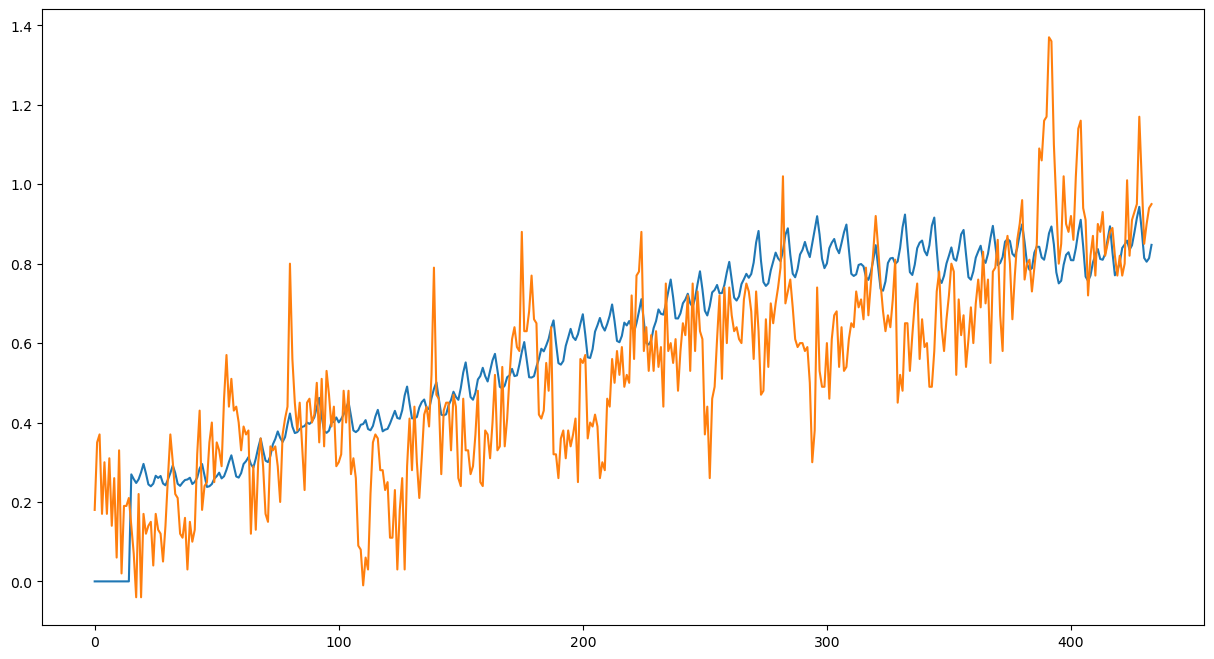

In [12]:
plt.figure(figsize=(15,8))
plt.plot(pred)
plt.plot(data.data.reset_index()[y_vals[0]])